# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

## Checking GPU

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 16
img_height = 48
img_width = 48
color_mode = 'rgb' # One of "grayscale", "rgb", "rgba".
validation_split = 0.2

dataset = "CK+"
model_name = "VGG16"

train_data = "data/"+ dataset + "/train/"
test_data = "data/"+ dataset + "/test/"

print(train_data)
print(test_data)

data/CK+/train/
data/CK+/test/


Load the data into the datasets

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    color_mode = color_mode,
    validation_split=validation_split,
    label_mode="categorical",
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 720 files belonging to 7 classes.
Using 576 files for training.
Found 720 files belonging to 7 classes.
Using 144 files for validation.
Found 182 files belonging to 7 classes.


2022-03-24 14:57:23.652950: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


View the classes in the dataset

In [5]:
class_names = test_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## Configuring the Datset
Enable buffered prefetching so you can yield data from disk without having I/O become blocking

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Creating the Model

In [11]:
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense 
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

from models import *




model = model_ResNet50_V1()

TypeError: reload() argument must be a module

## Compile the model

In [8]:
model.compile(optimizer = Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [9]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 3)    0           ['img[0][0]']                    
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 24, 24, 64)   96          ['conv1[0][0]']                  
                                                                                           

                                                                                                  
 con3a2.1 (Conv2D)              (None, 6, 6, 128)    32896       ['activation_9[0][0]']           
                                                                                                  
 bn3a2a (BatchNormalization)    (None, 6, 6, 128)    24          ['con3a2.1[0][0]']               
                                                                                                  
 activation_10 (Activation)     (None, 6, 6, 128)    0           ['bn3a2a[0][0]']                 
                                                                                                  
 con3a2.2 (Conv2D)              (None, 6, 6, 128)    147584      ['activation_10[0][0]']          
                                                                                                  
 bn3a2b (BatchNormalization)    (None, 6, 6, 128)    24          ['con3a2.2[0][0]']               
          

                                                                                                  
 add_6 (Add)                    (None, 6, 6, 512)    0           ['bn3d2c[0][0]',                 
                                                                  'activation_18[0][0]']          
                                                                                                  
 activation_21 (Activation)     (None, 6, 6, 512)    0           ['add_6[0][0]']                  
                                                                                                  
 con4a2.1 (Conv2D)              (None, 3, 3, 256)    131328      ['activation_21[0][0]']          
                                                                                                  
 bn4a2a (BatchNormalization)    (None, 3, 3, 256)    12          ['con4a2.1[0][0]']               
                                                                                                  
 activatio

 activation_32 (Activation)     (None, 3, 3, 256)    0           ['bn4d2b[0][0]']                 
                                                                                                  
 con4d2.3 (Conv2D)              (None, 3, 3, 1024)   263168      ['activation_32[0][0]']          
                                                                                                  
 bn4d2c (BatchNormalization)    (None, 3, 3, 1024)   12          ['con4d2.3[0][0]']               
                                                                                                  
 add_10 (Add)                   (None, 3, 3, 1024)   0           ['bn4d2c[0][0]',                 
                                                                  'activation_30[0][0]']          
                                                                                                  
 activation_33 (Activation)     (None, 3, 3, 1024)   0           ['add_10[0][0]']                 
          

                                                                                                  
 con5b2.2 (Conv2D)              (None, 2, 2, 512)    2359808     ['activation_43[0][0]']          
                                                                                                  
 bn5b2b (BatchNormalization)    (None, 2, 2, 512)    8           ['con5b2.2[0][0]']               
                                                                                                  
 activation_44 (Activation)     (None, 2, 2, 512)    0           ['bn5b2b[0][0]']                 
                                                                                                  
 con5b2.3 (Conv2D)              (None, 2, 2, 2048)   1050624     ['activation_44[0][0]']          
                                                                                                  
 bn5b2c (BatchNormalization)    (None, 2, 2, 2048)   8           ['con5b2.3[0][0]']               
          

Plot the the CNN Model

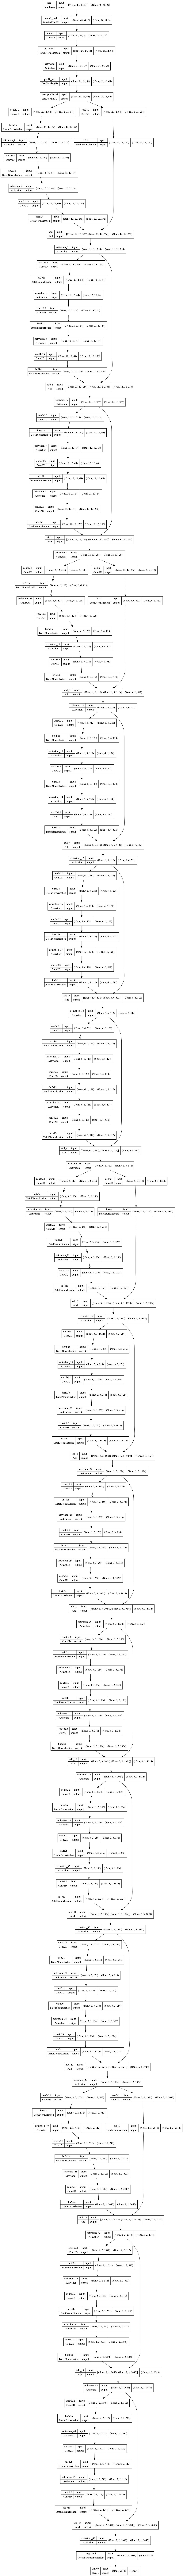

In [10]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image 


plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png', width = 400)

## Train the Model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

name = [model_name, dataset , 'weights']
name = '_'.join(name) + ".hdf5"

checkpoint_file_path = "models/" + name


checkpoint = ModelCheckpoint(filepath=checkpoint_file_path,
                            monitor="val_loss",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode= "auto",
                            save_freq= "epoch",
                            options=None)


early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0, # Minimum change in the monitored quantity to qualify as an improvemen
                          patience=10, # Number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')

In [12]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
#     callbacks = [checkpoint,early_stop] 
)

Epoch 1/10
36/36 [==============================] - 9s 87ms/step - loss: 1.8167 - accuracy: 0.5938 - val_loss: 22.0313 - val_accuracy: 0.6528
Epoch 2/10
36/36 [==============================] - 2s 62ms/step - loss: 1.3759 - accuracy: 0.6458 - val_loss: 2.3965 - val_accuracy: 0.4792
Epoch 3/10
36/36 [==============================] - 2s 65ms/step - loss: 1.2452 - accuracy: 0.6632 - val_loss: 1.7263 - val_accuracy: 0.7292
Epoch 4/10
36/36 [==============================] - 2s 62ms/step - loss: 1.0296 - accuracy: 0.7344 - val_loss: 0.9808 - val_accuracy: 0.8125
Epoch 5/10
36/36 [==============================] - 2s 61ms/step - loss: 0.8176 - accuracy: 0.7865 - val_loss: 0.7585 - val_accuracy: 0.7986
Epoch 6/10
36/36 [==============================] - 2s 61ms/step - loss: 0.6378 - accuracy: 0.8194 - val_loss: 0.6476 - val_accuracy: 0.7847
Epoch 7/10
36/36 [==============================] - 2s 62ms/step - loss: 0.5174 - accuracy: 0.8611 - val_loss: 0.5397 - val_accuracy: 0.8819
Epoch 8/10
3

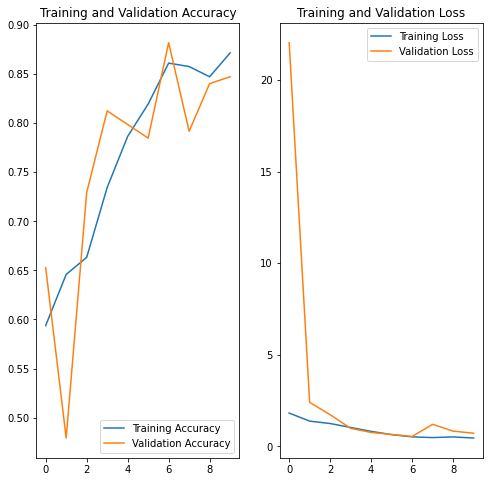

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Evaluate the Model

In [14]:
print("Evaluate")
model.load_weights(checkpoint_file_path) #Load the best weights from the file
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate


KeyError: "Unable to open object (object 'img' doesn't exist)"

## Confusion Matrix and Classification

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report

# defines which dataset we want to show the confusion matrix and classification report 
dataset = test_ds

predition_list = []
label_list = []

# Get predictions from the model
predictions = model.predict(dataset)
for prediction in predictions:
    predition_list.append(np.argmax(prediction))
    
# Get lables from the test set
labels = np.concatenate([y for x, y in dataset], axis=0)
for label in labels:
    label_list.append(np.argmax(label))
    
# create a confusion matrix
confusion_mtx = tf.math.confusion_matrix(label_list, predition_list , num_classes=7)

# Function that displays the confusion matrix
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


print(classification_report(label_list, predition_list, target_names=class_names))
show_confusion_matrix(confusion_mtx, class_names)
